# What is Murcko Scaffold?
Murcko scaffold is the method for extracting molecule backbone. Murcko scaffold is obtained by extracting the ring structures and the linkers that connect them.

Extracting Murcko scaffold enable us to cluster the structure of the molecule. Therefore, it is possible to separate molecules with extremely similar structures from train and validation.We obtain structurally divirse data splits by this technique.

This notebook presents two methods for extracting scaffold. I don't know which method is the better for this task, so please let me know in the comments.

In [ ]:
!conda install -y -c rdkit rdkit

In [ ]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GroupKFold


from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

from collections import defaultdict

# Method 1: Basic Murcko Scaffold
Basic Murcko Scaffold extracts scaffold considering the difference in atoms.

# Method 2: Bemis/Murcko Scaffold (BM Scaffold)
Basic Murcko Scaffold treats as different scaffolds when the shape is the same but only the atoms are different as shown in the image below.(left scaffold: "c1ccccc1" right scaffold: "c1ccncc1)

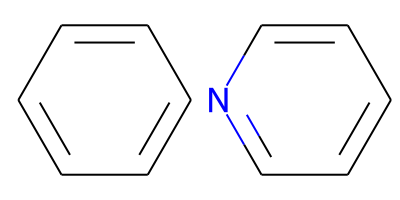

BM scaffold extracts scaffold by ignoring the bond type and the difference between atoms and focusing only on the shape.
When extraction of BM scaffold fails, return basic Murcko Scaffold in this notebook. The image below is an example of a scaffold that fails to extract the BM scaffold. In BM scaffold, all atoms are replaced with carbon (valence=4), so when a phosphorus (valence=5) atom appears, for example, the valence is insufficient and an error is thrown.

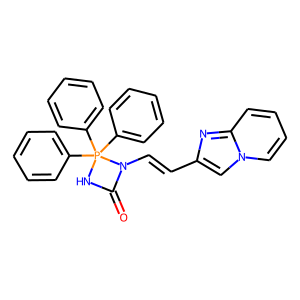

# Read csv and extract scaffold(SMILES format)
SMILES is a string notation used to describe the structure of a compound. (In cheminformatics, SMILES is a more popular format than InChI, as far as I know:))

In [ ]:
train = pd.read_csv('../input/bms-molecular-translation/train_labels.csv')

def get_train_file_path(image_id):
    return "../input/bms-molecular-translation/train/{}/{}/{}/{}.png".format(
        image_id[0], image_id[1], image_id[2], image_id 
    )

# method 1
def get_basic_marcko_scaffold(inchi):
    return MurckoScaffold.MurckoScaffoldSmiles(mol=Chem.MolFromInchi(inchi),includeChirality=False)

# method 2
def get_bm_scaffold(smiles):
    try:
        scaffold = Chem.MolToSmiles(MurckoScaffold.MakeScaffoldGeneric(mol=Chem.MolFromSmiles(smiles)))
    except Exception:
        print("Raise AtomValenceException, return basic Murcko Scaffold")
        scaffold = smiles
    return scaffold

train['file_path'] = train['image_id'].progress_apply(get_train_file_path)
train["basic_murcko_scaffold"] = train["InChI"].progress_apply(get_basic_marcko_scaffold)
train["BM_scaffold"] = train["basic_murcko_scaffold"].progress_apply(get_bm_scaffold)
print(f'train.shape: {train.shape}')
display(train.head())

In [ ]:
train["basic_murcko_scaffold"].value_counts().head(20)

## The data `scaffold == ""` don't have scaffold because they don't have any ring structures.
For example, 10 molecules structures are illustrated.

In [ ]:
def InchiToImage(Inchi):
    display(Chem.Draw.MolToImage(Chem.MolFromInchi(Inchi)))
def SmilesToImage(Smiles):
    display(Chem.Draw.MolToImage(Chem.MolFromSmiles(Smiles)))

In [ ]:
for image_id in train[train["basic_murcko_scaffold"]==""]["image_id"].head(10):
    mol_data = train[train["image_id"]==image_id].iloc[0,:]
    print("image_id: "+mol_data["image_id"])
    
    InchiToImage(mol_data["InChI"])
    
    image = cv2.imread(mol_data["file_path"])
    plt.imshow(image)
    plt.show()

# Group KFold

## By basic Murcko Scaffold

In [ ]:
i=0
gkf = GroupKFold(n_splits=5)
for train_index,valid_index in gkf.split(train,groups=train["basic_murcko_scaffold"]):
    train_df = train.iloc[train_index,:]
    valid_df = train.iloc[valid_index,:]
    print("Fold %d: train size: %d , valid size: %d"%(i,train_df.shape[0],valid_df.shape[0]))
    
    # MS means Murcko Scaffold.
    train_df.to_csv("train_MS_%d.csv"%i,index=False)
    valid_df.to_csv("valid_MS_%d.csv"%i,index=False)
    i+=1

## By BM Scaffold

In [ ]:
i=0
gkf = GroupKFold(n_splits=5)
for train_index,valid_index in gkf.split(train,groups=train["BM_scaffold"]):
    train_df = train.iloc[train_index,:]
    valid_df = train.iloc[valid_index,:]
    print("Fold %d: train size: %d , valid size: %d"%(i,train_df.shape[0],valid_df.shape[0]))
    
    # BMS means BM Scaffold.
    train_df.to_csv("train_BMS_%d.csv"%i,index=False)
    valid_df.to_csv("valid_BMS_%d.csv"%i,index=False)
    i+=1